In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sys
sys.path.append("../")

from evaluate_script import predict

# Prediction for zero filled average beat

In [2]:
data_array = np.load("../data/one_beat_array.npy")
pred_zero_fill = predict(data_array)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 605/605 [01:12<00:00,  8.35it/s]


In [3]:
df = pd.read_csv("../data/average_beat_metadata.csv")
df.head()

,exam_id,data_arr_idx,start_beat,end_beat,channel_used
0,1750214,0,1893,2358,0
1,1688724,1,1928,2288,1
2,1771393,2,1939,2266,0
3,1793030,3,1934,2275,0
4,1717689,4,1973,2197,1


In [4]:
for i in range(len(data_array)):
    i = 0
    
    for chan in range(12):
        chan = 0
        arr = data_array[i, :, chan]
        
        idx_min = int((np.nonzero(arr))[0][0])
        begin_fill = arr[idx_min]
        
        idx_max = int((np.nonzero(arr))[0][-1])
        end_fill = arr[idx_max]
        data_array[i, :idx_min, chan] = begin_fill
        data_array[i, idx_max:, chan] = end_fill

In [5]:
pred_dc_fill = predict(data_array)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 605/605 [01:23<00:00,  7.25it/s]


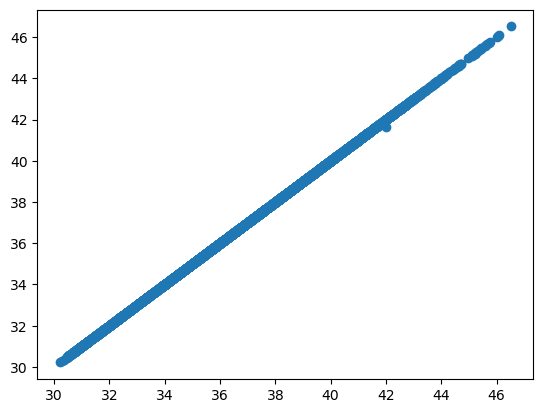

In [6]:
plt.scatter(
    pred_zero_fill,
    pred_dc_fill,
)

In [7]:
(abs(pred_dc_fill - pred_zero_fill) > 0.05)

array([ True, False, False, ..., False, False, False], shape=(6044,))

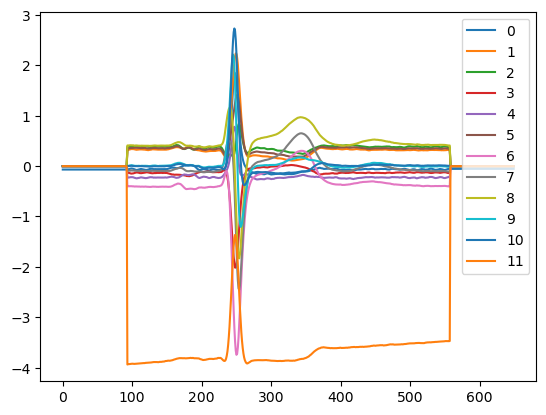

In [13]:
# data_array = np.load("../data/one_beat_array.npy")
for chan in range(12):
    plt.plot(data_array[0, 1800:2450, chan], label=chan)
plt.legend()
plt.show()

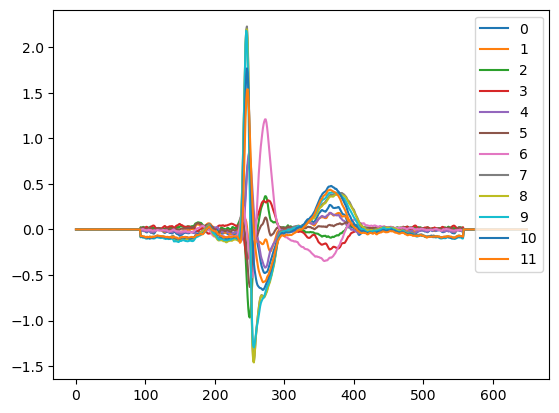

In [15]:
# data_array = np.load("../data/one_beat_array.npy")
subject = 123
for chan in range(12):
    plt.plot(data_array[subject, 1800:2450, chan], label=chan)
plt.legend()
plt.show()

In [8]:
total_time = 10  # 10 seconds per ECG 
total_pixels = 4096 
pixel_per_sec = total_pixels / total_time
pixel_per_sec

409.6

In [9]:
# Remove 5 milli-second just before the QRS peak

blank_pixel_len = 0.005 * total_pixels / total_time
blank_pixel_len

2.048

In [10]:
data_array[:, 2046:2048, :] = 0
pred_200hz_asc = predict(data_array)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 605/605 [01:32<00:00,  6.52it/s]


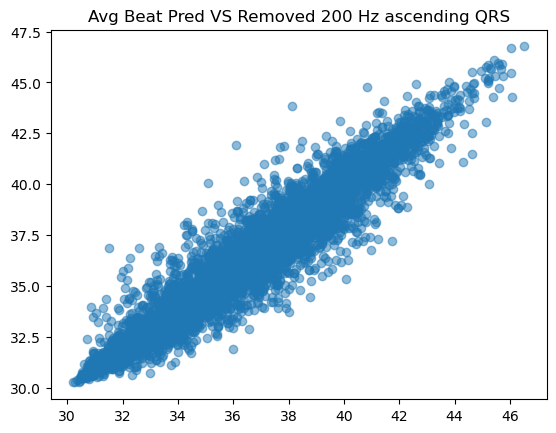

In [11]:
plt.scatter(
    pred_zero_fill,
    pred_200hz_asc,
    alpha=0.5
)
plt.title("Avg Beat Pred VS Removed 200 Hz ascending QRS")
plt.show()

In [12]:
data_array = np.load("../data/one_beat_array.npy")
data_array[:, 2048:2050, :] = 0
pred_200hz_desc = predict(data_array)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 605/605 [01:33<00:00,  6.50it/s]


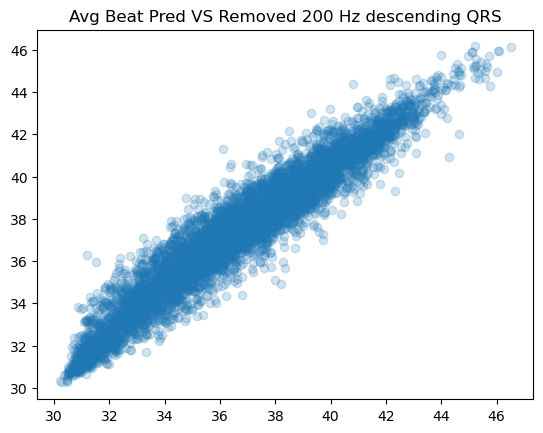

In [14]:
plt.scatter(
    pred_zero_fill,
    pred_200hz_desc,
    alpha=0.2,
)
plt.title("Avg Beat Pred VS Removed 200 Hz descending QRS")
plt.show()

In [2]:
data_array = np.load("../data/one_beat_array.npy")
for i in range(len(data_array)):
    for chan in range(12):
        data_array[i, 2046:2048, chan] = data_array[i, 2045, chan]
pred_200hz_asc_dc = predict(data_array)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 605/605 [01:13<00:00,  8.22it/s]


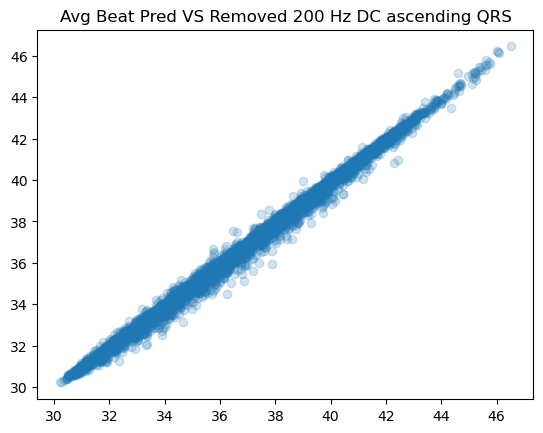

In [5]:
plt.scatter(
    pred_zero_fill,
    pred_200hz_asc_dc,
    alpha=0.2,
)
plt.title("Avg Beat Pred VS Removed 200 Hz DC ascending QRS")
plt.show()

In [6]:
data_array = np.load("../data/one_beat_array.npy")
for i in range(len(data_array)):
    for chan in range(12):
        data_array[i, 2048:2050, chan] = data_array[i, 2047, chan]
pred_200hz_desc_dc = predict(data_array)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 605/605 [01:13<00:00,  8.25it/s]


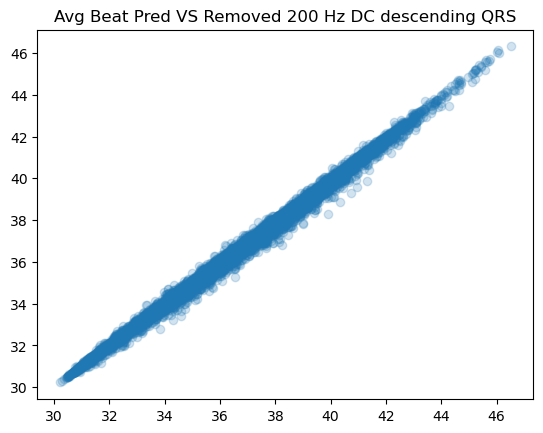

In [7]:
plt.scatter(
    pred_zero_fill,
    pred_200hz_desc_dc,
    alpha=0.2,
)
plt.title("Avg Beat Pred VS Removed 200 Hz DC descending QRS")
plt.show()

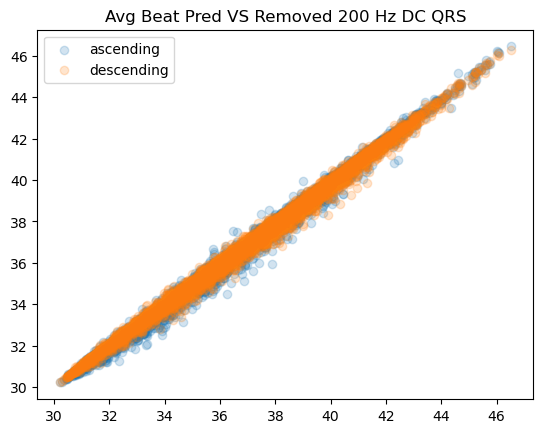

In [8]:
plt.scatter(
    pred_zero_fill,
    pred_200hz_asc_dc,
    alpha=0.2,
    label='ascending',
)
plt.scatter(
    pred_zero_fill,
    pred_200hz_desc_dc,
    alpha=0.2,
    label='descending',
)
plt.legend()
plt.title("Avg Beat Pred VS Removed 200 Hz DC QRS")
plt.show()
